## Plan de fine-tuning con EfficientNetV2-S

**Objetivo:** adaptar un modelo preentrenado en ImageNet (**EfficientNetV2-S**) para clasificar *melanoma vs no melanoma* en HAM10000.

**Pasos que haremos:**
1) **Cargar EfficientNetV2-S** sin la “top” (`include_top=False`) y con pesos de ImageNet.  
2) **Congelar el backbone** (todas las capas base) y **entrenar solo la cabeza nueva**  
   (GAP → Dense(128, ReLU, Dropout) → Dense(1, Sigmoid)) usando **class_weight** para compensar el desbalance.  
3) **Descongelar parcialmente** las últimas capas del backbone y hacer **fine-tuning** con **LR bajo**.  
4) **Evaluar** con ROC-AUC, PR-AUC y ajustar **umbral** para priorizar sensibilidad (recall) en melanoma.  
5) **Guardar pesos** y dejar reproducibilidad (seeds, versiones).

*Motivo de elegir EfficientNetV2-S:* excelente balance **precisión/velocidad/tamaño** para Colab y buen desempeño en imágenes médicas.


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'skin-cancer-mnist-ham10000' dataset.
Path to dataset files: /kaggle/input/skin-cancer-mnist-ham10000


# Analisis exploratorio del dataset y preparación de datos

## Preparación de datos:

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from glob import glob

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [ ]:
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'skin-cancer-mnist-ham10000' dataset.
Path to dataset files: /kaggle/input/skin-cancer-mnist-ham10000


In [ ]:
metadata_file = os.path.join(path, 'HAM10000_metadata.csv')
df = pd.read_csv(metadata_file)

print("="*60)
print("INFORMACIÓN GENERAL DEL DATASET")
print("="*60)
print(f"\nDimensiones del dataset: {df.shape}")
print(f"\nColumnas disponibles:\n{df.columns.tolist()}")
print(f"\nPrimeras filas del dataset:")
display(df.head())
print(f"\nInformación del dataset:")
df.info()

INFORMACIÓN GENERAL DEL DATASET

Dimensiones del dataset: (10015, 7)

Columnas disponibles:
['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization']

Primeras filas del dataset:


lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [ ]:
# Crear diccionario con rutas de todas las imágenes
image_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                   for x in glob(os.path.join(path, '**', '*.jpg'), recursive=True)}

df['path'] = df['image_id'].map(image_path_dict.get)
print(f"Imágenes encontradas: {df['path'].notna().sum()} de {len(df)}")
print(f"Imágenes faltantes: {df['path'].isna().sum()}")

Imágenes encontradas: 10015 de 10015
Imágenes faltantes: 0


## Análisis de Distribución de Clases

El dataset HAM10000 contiene 7 categorías diagnósticas diferentes de lesiones cutáneas.

In [ ]:
class_names = {
    'mel': 'Melanoma',
    'nv': 'Melanocytic nevi',
    'bkl': 'Benign keratosis',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

print("="*60)
print("ANÁLISIS DE CLASES")
print("="*60)

print("\nDistribución de clases:")
class_counts = df['dx'].value_counts()
for dx, count in class_counts.items():
    print(f"{class_names[dx]} ({dx}): {count} imágenes ({count/len(df)*100:.2f}%)")

ANÁLISIS DE CLASES

Distribución de clases:
Melanocytic nevi (nv): 6705 imágenes (66.95%)
Melanoma (mel): 1113 imágenes (11.11%)
Benign keratosis (bkl): 1099 imágenes (10.97%)
Basal cell carcinoma (bcc): 514 imágenes (5.13%)
Actinic keratoses (akiec): 327 imágenes (3.27%)
Vascular lesions (vasc): 142 imágenes (1.42%)
Dermatofibroma (df): 115 imágenes (1.15%)


In [ ]:
# Crear columna binaria: melanoma vs no melanoma
df['is_melanoma'] = df['dx'].apply(lambda x: 'Melanoma' if x == 'mel' else 'No Melanoma')

print("="*60)
print("CLASIFICACIÓN BINARIA: MELANOMA vs NO MELANOMA")
print("="*60)
print(df['is_melanoma'].value_counts())
print(f"\nPorcentaje de melanomas: {(df['is_melanoma']=='Melanoma').sum()/len(df)*100:.2f}%")
print(f"Porcentaje de no melanomas: {(df['is_melanoma']=='No Melanoma').sum()/len(df)*100:.2f}%")
print(f"\nRatio de desbalance: 1:{(df['dx']!='mel').sum()/(df['dx']=='mel').sum():.2f}")

CLASIFICACIÓN BINARIA: MELANOMA vs NO MELANOMA
is_melanoma
No Melanoma    8902
Melanoma       1113
Name: count, dtype: int64

Porcentaje de melanomas: 11.11%
Porcentaje de no melanomas: 88.89%

Ratio de desbalance: 1:8.00


In [ ]:
print("="*60)
print("ANÁLISIS DEMOGRÁFICO")
print("="*60)

print(f"\nDistribución por género:")
print(df['sex'].value_counts())
print(f"\n% por género:")
print(df['sex'].value_counts(normalize=True) * 100)

print(f"\nEstadísticas de edad:")
print(df['age'].describe())

print(f"\nLocalización más común:")
print(df['localization'].value_counts().head(10))

ANÁLISIS DEMOGRÁFICO

Distribución por género:
sex
male       5406
female     4552
unknown      57
Name: count, dtype: int64

% por género:
sex
male       53.979031
female     45.451822
unknown     0.569146
Name: proportion, dtype: float64

Estadísticas de edad:
count    9958.000000
mean       51.863828
std        16.968614
min         0.000000
25%        40.000000
50%        50.000000
75%        65.000000
max        85.000000
Name: age, dtype: float64

Localización más común:
localization
back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
Name: count, dtype: int64


In [ ]:
fig = plt.figure(figsize=(18, 12))

# Gráfico 1: Distribución de todas las clases
ax1 = plt.subplot(2, 3, 1)
class_counts.plot(kind='bar', color='steelblue', ax=ax1)
ax1.set_title('Distribución de las 7 Clases de Lesiones', fontsize=12, fontweight='bold')
ax1.set_xlabel('Tipo de Lesión')
ax1.set_ylabel('Cantidad de Imágenes')
ax1.set_xticklabels([class_names[dx] for dx in class_counts.index], rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Gráfico 2: Clasificación binaria
ax2 = plt.subplot(2, 3, 2)
binary_counts = df['is_melanoma'].value_counts()
colors = ['#d62728', '#2ca02c']
ax2.pie(binary_counts, labels=binary_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=90)
ax2.set_title('Melanoma vs No Melanoma', fontsize=12, fontweight='bold')

# Gráfico 3: Distribución por género
ax3 = plt.subplot(2, 3, 3)
df['sex'].value_counts().plot(kind='bar', color='coral', ax=ax3)
ax3.set_title('Distribución por Género', fontsize=12, fontweight='bold')
ax3.set_xlabel('Género')
ax3.set_ylabel('Cantidad')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)
ax3.grid(axis='y', alpha=0.3)

# Gráfico 4: Distribución de edad
ax4 = plt.subplot(2, 3, 4)
df['age'].hist(bins=30, color='mediumpurple', edgecolor='black', ax=ax4)
ax4.set_title('Distribución de Edad', fontsize=12, fontweight='bold')
ax4.set_xlabel('Edad')
ax4.set_ylabel('Frecuencia')
ax4.grid(axis='y', alpha=0.3)

# Gráfico 5: Localización de lesiones
ax5 = plt.subplot(2, 3, 5)
top_locations = df['localization'].value_counts().head(10)
top_locations.plot(kind='barh', color='teal', ax=ax5)
ax5.set_title('Top 10 Localizaciones de Lesiones', fontsize=12, fontweight='bold')
ax5.set_xlabel('Cantidad')
ax5.set_ylabel('Localización')
ax5.grid(axis='x', alpha=0.3)

# Gráfico 6: Melanoma por género
ax6 = plt.subplot(2, 3, 6)
melanoma_by_sex = pd.crosstab(df['sex'], df['is_melanoma'])
melanoma_by_sex.plot(kind='bar', stacked=False, color=['#d62728', '#2ca02c'], ax=ax6)
ax6.set_title('Melanoma vs No Melanoma por Género', fontsize=12, fontweight='bold')
ax6.set_xlabel('Género')
ax6.set_ylabel('Cantidad')
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=0)
ax6.legend(title='Clasificación')
ax6.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('analisis_exploratorio_ham10000.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráficos guardados en 'analisis_exploratorio_ham10000.png'")


✓ Gráficos guardados en 'analisis_exploratorio_ham10000.png'


## Comparación Visual del dataset

A continuación se muestran 10 ejemplos de melanomas y 10 ejemplos de no melanomas para visualizar las diferencias.

VISUALIZACIÓN DE IMÁGENES DE MUESTRA


/tmp/ipython-input-3182596219.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  non_melanoma_samples = df[df['dx'] != 'mel'].groupby('dx', group_keys=False).apply(


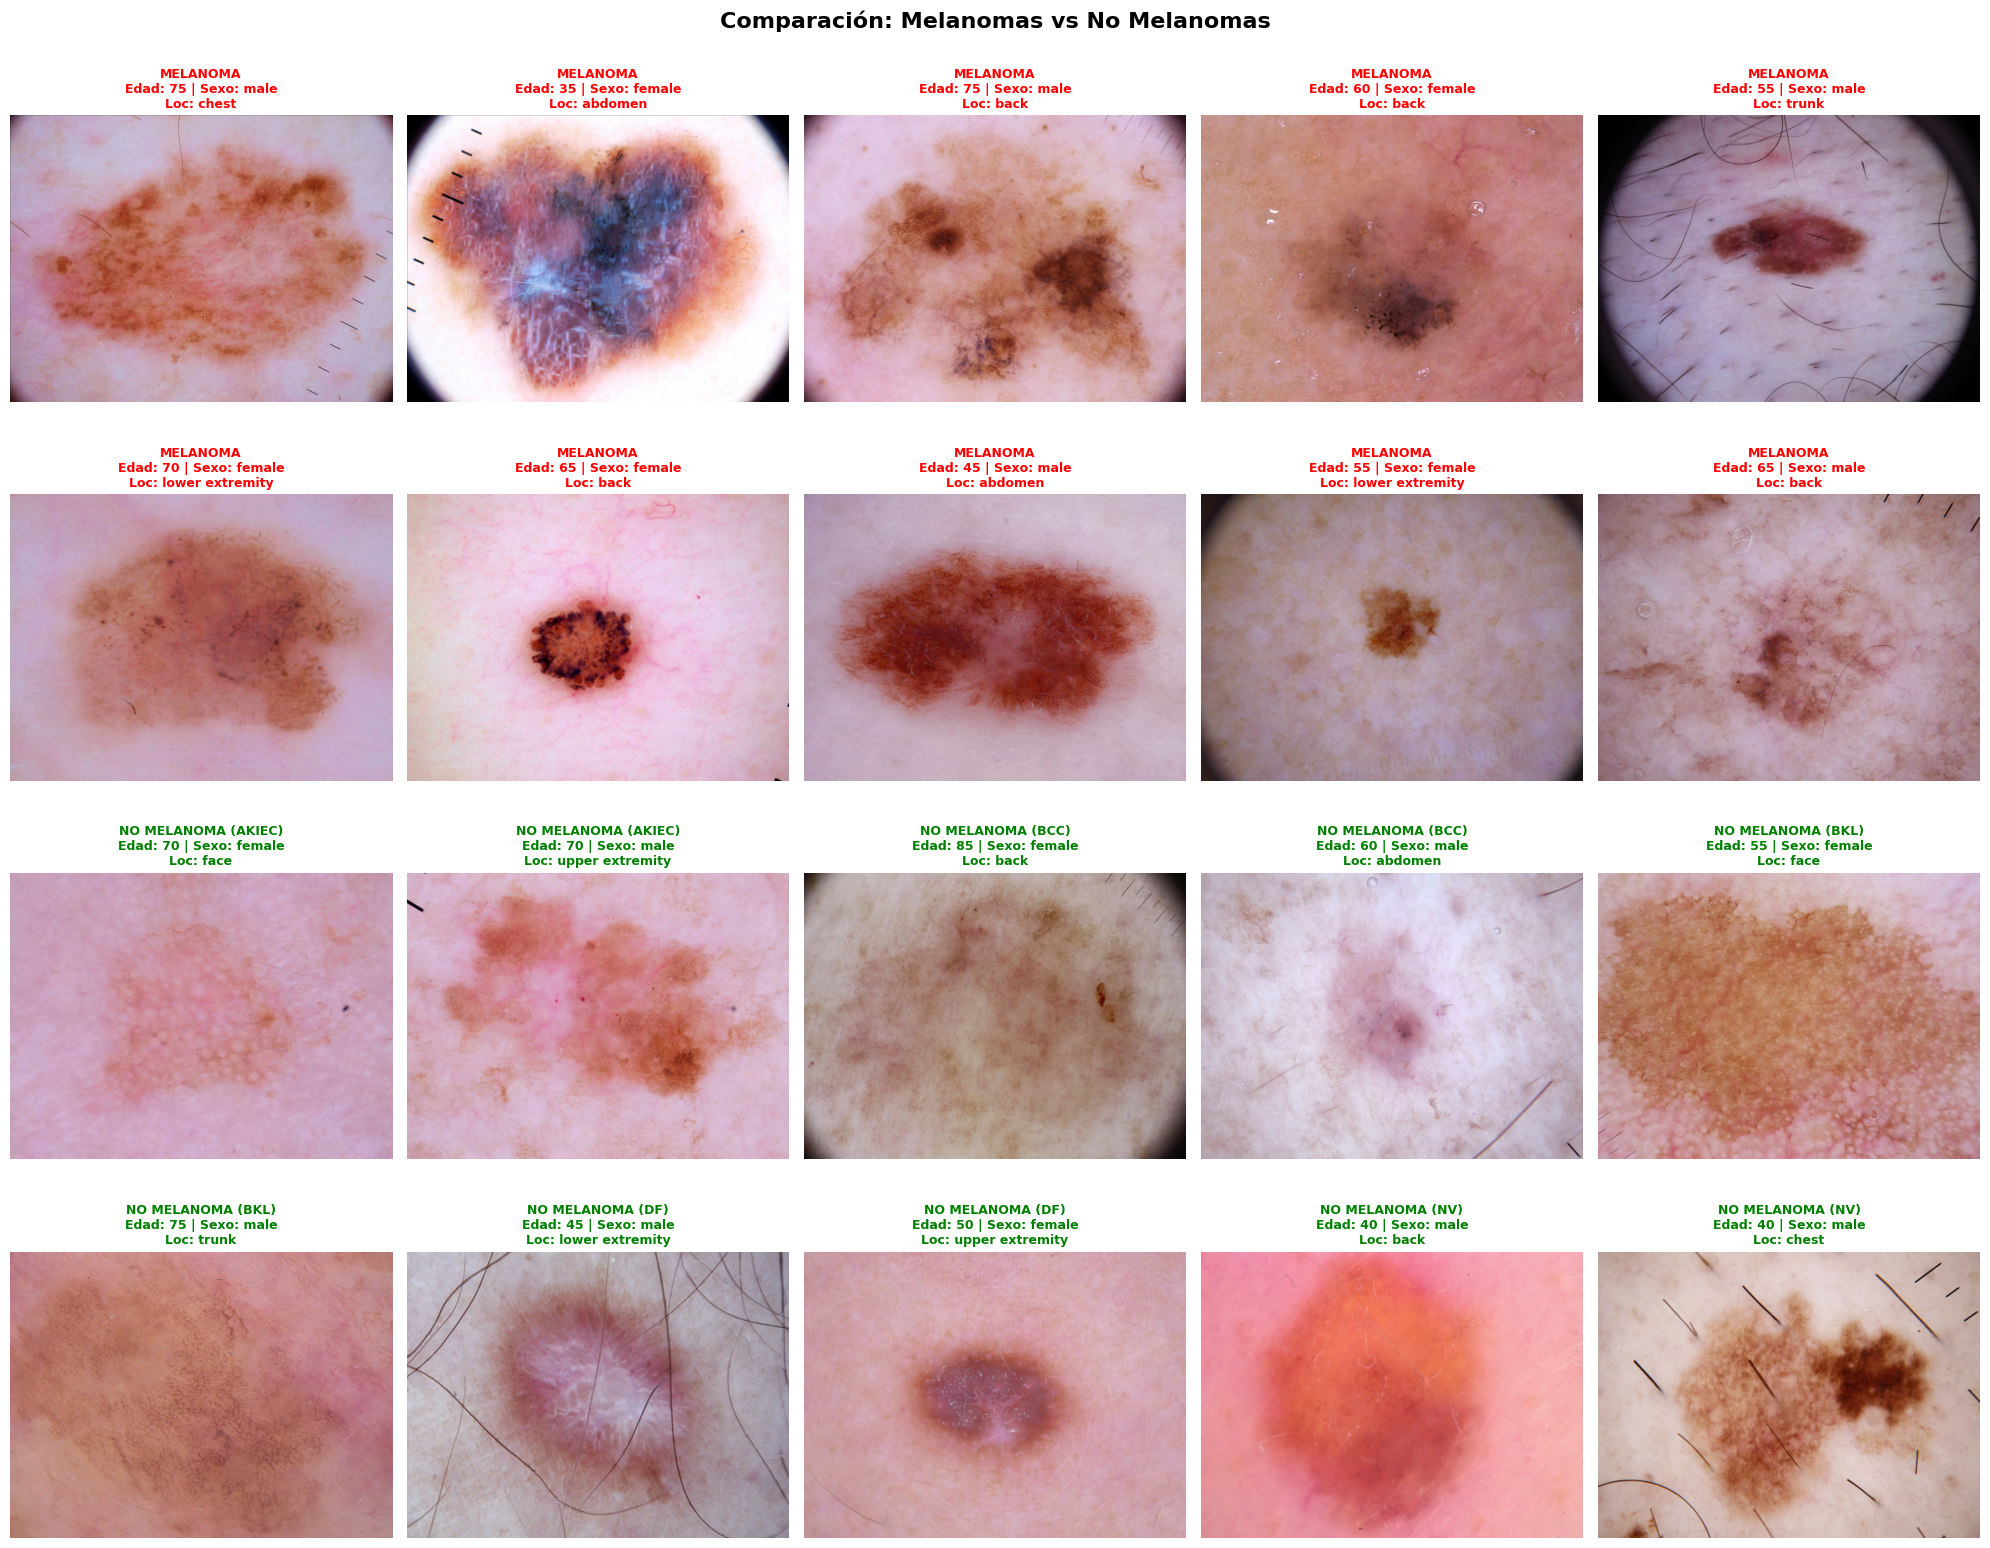

In [ ]:
print("="*60)
print("VISUALIZACIÓN DE IMÁGENES DE MUESTRA")
print("="*60)

# Seleccionar 10 imágenes de melanoma
melanoma_samples = df[df['dx'] == 'mel'].sample(n=10, random_state=42)

# Seleccionar 10 imágenes de no melanoma (variedad de clases)
non_melanoma_samples = df[df['dx'] != 'mel'].groupby('dx', group_keys=False).apply(
    lambda x: x.sample(min(2, len(x)), random_state=42)
).head(10)

fig, axes = plt.subplots(4, 5, figsize=(20, 16))
fig.suptitle('Comparación: Melanomas vs No Melanomas', fontsize=16, fontweight='bold', y=0.995)

# Mostrar melanomas (primeras 2 filas)
for idx, (i, row) in enumerate(melanoma_samples.iterrows()):
    ax = axes[idx//5, idx%5]
    img_path = row['path']
    if pd.notna(img_path) and os.path.exists(img_path):
        img = Image.open(img_path)
        ax.imshow(img)
        edad_str = f"{row['age']:.0f}" if pd.notna(row['age']) else 'N/A'
        ax.set_title(f"MELANOMA\nEdad: {edad_str} | Sexo: {row['sex']}\nLoc: {row['localization']}",
                     fontsize=9, color='red', fontweight='bold')
    ax.axis('off')

# Mostrar no melanomas (últimas 2 filas)
for idx, (i, row) in enumerate(non_melanoma_samples.iterrows()):
    ax = axes[(idx//5) + 2, idx%5]
    img_path = row['path']
    if pd.notna(img_path) and os.path.exists(img_path):
        img = Image.open(img_path)
        ax.imshow(img)
        edad_str = f"{row['age']:.0f}" if pd.notna(row['age']) else 'N/A'
        ax.set_title(f"NO MELANOMA ({row['dx'].upper()})\nEdad: {edad_str} | Sexo: {row['sex']}\nLoc: {row['localization']}",
                     fontsize=9, color='green', fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()



In [ ]:
print("="*60)
print("ESTADÍSTICAS DETALLADAS POR CLASE")
print("="*60)

for dx in df['dx'].unique():
    subset = df[df['dx'] == dx]
    print(f"\n{class_names[dx]} ({dx}):")
    print(f"  - Total de imágenes: {len(subset)}")
    print(f"  - Edad promedio: {subset['age'].mean():.1f} años")
    print(f"  - Distribución por género:")
    print(f"    {subset['sex'].value_counts().to_dict()}")
    print(f"  - Localización más común: {subset['localization'].mode()[0] if len(subset['localization'].mode()) > 0 else 'N/A'}")

ESTADÍSTICAS DETALLADAS POR CLASE

Benign keratosis (bkl):
  - Total de imágenes: 1099
  - Edad promedio: 64.3 años
  - Distribución por género:
    {'male': 626, 'female': 463, 'unknown': 10}
  - Localización más común: face

Melanocytic nevi (nv):
  - Total de imágenes: 6705
  - Edad promedio: 46.5 años
  - Distribución por género:
    {'male': 3421, 'female': 3237, 'unknown': 47}
  - Localización más común: lower extremity

Dermatofibroma (df):
  - Total de imágenes: 115
  - Edad promedio: 53.0 años
  - Distribución por género:
    {'male': 63, 'female': 52}
  - Localización más común: lower extremity

Melanoma (mel):
  - Total de imágenes: 1113
  - Edad promedio: 60.7 años
  - Distribución por género:
    {'male': 689, 'female': 424}
  - Localización más común: back

Vascular lesions (vasc):
  - Total de imágenes: 142
  - Edad promedio: 51.4 años
  - Distribución por género:
    {'female': 73, 'male': 69}
  - Localización más común: trunk

Basal cell carcinoma (bcc):
  - Total de i

In [ ]:
print("="*60)
print("RESUMEN ESTADÍSTICO FINAL")
print("="*60)
print(f"\nTotal de imágenes: {len(df)}")
print(f"Total de melanomas: {(df['dx']=='mel').sum()}")
print(f"Total de no melanomas: {(df['dx']!='mel').sum()}")
print(f"Ratio de desbalance: 1:{(df['dx']!='mel').sum()/(df['dx']=='mel').sum():.2f}")

print(f"\nLesiones únicas (lesion_id): {df['lesion_id'].nunique()}")
print(f"Imágenes duplicadas de la misma lesión: {len(df) - df['lesion_id'].nunique()}")

print(f"\nRango de edad: {df['age'].min():.0f} - {df['age'].max():.0f} años")
print(f"Edad promedio: {df['age'].mean():.1f} años")
print(f"Mediana de edad: {df['age'].median():.1f} años")

print(f"\nDatos faltantes:")
print(df.isnull().sum())

RESUMEN ESTADÍSTICO FINAL

Total de imágenes: 10015
Total de melanomas: 1113
Total de no melanomas: 8902
Ratio de desbalance: 1:8.00

Lesiones únicas (lesion_id): 7470
Imágenes duplicadas de la misma lesión: 2545

Rango de edad: 0 - 85 años
Edad promedio: 51.9 años
Mediana de edad: 50.0 años

Datos faltantes:
lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
path             0
is_melanoma      0
dtype: int64


# Normalización de imagenes


Procesamiento y configuración de imagenes

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import cv2
from tqdm import tqdm

# Configuración
IMG_SIZE = 64  # Cambiado a 64x64
BATCH_SIZE = 32
RANDOM_STATE = 42


In [ ]:
def load_and_preprocess_images(dataframe, img_size=64):
    """
    Carga y preprocesa todas las imágenes del dataset

    Args:
        dataframe: DataFrame con columna 'path' con rutas de imágenes
        img_size: Tamaño objetivo para redimensionar (default: 64x64)

    Returns:
        images: Array numpy con imágenes normalizadas
        valid_indices: Índices de imágenes válidas cargadas
    """
    images = []
    valid_indices = []

    print(f"Cargando {len(dataframe)} imágenes...")

    for idx, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        img_path = row['path']

        if pd.notna(img_path) and os.path.exists(img_path):
            try:
                # Cargar imagen con OpenCV
                img = cv2.imread(img_path)

                # Convertir de BGR a RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Redimensionar a 64x64
                img = cv2.resize(img, (img_size, img_size))

                # Normalizar valores de píxeles a rango [0, 1]
                img = img.astype('float32') / 255.0

                images.append(img)
                valid_indices.append(idx)

            except Exception as e:
                print(f"Error al cargar imagen {img_path}: {e}")
                continue

    images = np.array(images)
    print(f"\nImágenes cargadas exitosamente: {len(images)}")
    print(f"Shape del array: {images.shape}")
    print(f"Rango de valores: [{images.min():.3f}, {images.max():.3f}]")

    return images, valid_indices

# Cargar todas las imágenes
X, valid_indices = load_and_preprocess_images(df, img_size=IMG_SIZE)

# Filtrar el dataframe para mantener solo las imágenes válidas
df_valid = df.loc[valid_indices].reset_index(drop=True)
print(f"\nDataset válido: {len(df_valid)} muestras")


Cargando 10015 imágenes...


100%|██████████| 10015/10015 [03:16<00:00, 50.85it/s]



Imágenes cargadas exitosamente: 10015
Shape del array: (10015, 64, 64, 3)
Rango de valores: [0.000, 1.000]

Dataset válido: 10015 muestras


In [ ]:
# Crear labels binarios: 1 para melanoma, 0 para no melanoma
y = (df_valid['dx'] == 'mel').astype(int).values

print("="*60)
print("PREPARACIÓN DE LABELS")
print("="*60)
print(f"Total de muestras: {len(y)}")
print(f"Melanomas (clase 1): {y.sum()} ({y.sum()/len(y)*100:.2f}%)")
print(f"No melanomas (clase 0): {len(y) - y.sum()} ({(len(y)-y.sum())/len(y)*100:.2f}%)")
print(f"\nShape de X: {X.shape}")
print(f"Shape de y: {y.shape}")

PREPARACIÓN DE LABELS
Total de muestras: 10015
Melanomas (clase 1): 1113 (11.11%)
No melanomas (clase 0): 8902 (88.89%)

Shape de X: (10015, 64, 64, 3)
Shape de y: (10015,)


In [ ]:

# Paso 1: Separar train+val (90%) y test (10%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.10,
    random_state=RANDOM_STATE,
    stratify=y  # Mantener proporción de clases
)

# Paso 2: Separar train (70% del total) y validation (20% del total)
# 70/90 ≈ 0.778 para obtener 70% del dataset original
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.222,  # 20% del total = 0.222 de 90%
    random_state=RANDOM_STATE,
    stratify=y_temp  # Mantener proporción de clases
)

print("\nDivisión del dataset:")
print(f"{'Set':<15} {'Tamaño':<10} {'%':<10} {'Melanoma':<12} {'No Melanoma':<12}")
print("-" * 60)
print(f"{'Train':<15} {len(X_train):<10} {len(X_train)/len(X)*100:>6.1f}%   "
      f"{y_train.sum():<12} {len(y_train)-y_train.sum():<12}")
print(f"{'Validation':<15} {len(X_val):<10} {len(X_val)/len(X)*100:>6.1f}%   "
      f"{y_val.sum():<12} {len(y_val)-y_val.sum():<12}")
print(f"{'Test':<15} {len(X_test):<10} {len(X_test)/len(X)*100:>6.1f}%   "
      f"{y_test.sum():<12} {len(y_test)-y_test.sum():<12}")
print("-" * 60)
print(f"{'TOTAL':<15} {len(X):<10} {100.0:>6.1f}%   "
      f"{y.sum():<12} {len(y)-y.sum():<12}")

# Verificar proporciones de melanoma en cada set
print("\nProporción de melanoma por set:")
print(f"  Train:      {y_train.mean()*100:.2f}%")
print(f"  Validation: {y_val.mean()*100:.2f}%")
print(f"  Test:       {y_test.mean()*100:.2f}%")
print(f"  Original:   {y.mean()*100:.2f}%")


División del dataset:
Set             Tamaño     %          Melanoma     No Melanoma 
------------------------------------------------------------
Train           7012         70.0%   780          6232        
Validation      2001         20.0%   222          1779        
Test            1002         10.0%   111          891         
------------------------------------------------------------
TOTAL           10015       100.0%   1113         8902        

Proporción de melanoma por set:
  Train:      11.12%
  Validation: 11.09%
  Test:       11.08%
  Original:   11.11%


## Por qué **mantener HAM10000** y **mitigar el desbalance** (en vez de buscar otro dataset “perfectamente balanceado”)

**HAM10000** es actualmente el dataset público más usado para detección de melanoma, con buena calidad de anotaciones y tamaño adecuado para fine-tuning.  
Aunque presenta un desbalance de clases (≈11% melanomas vs 89% no melanomas), este reflejo de la prevalencia real lo convierte en un escenario clínico más verosímil y científicamente comparable con la literatura.

**Por qué no cambiarlo por un dataset “balanceado”:**
- **Realismo clínico:** en la práctica, los melanomas son minoría; un modelo entrenado en esta proporción aprende a priorizar sensibilidad en escenarios reales.  
- **Calidad y compatibilidad:** HAM10000 está curado, libremente accesible y utilizado en benchmarks (ISIC), lo que garantiza reproducibilidad y comparación con otros trabajos.  
- **Evitar sesgos artificiales:** forzar un balance duplicando imágenes o eliminando “no melanomas” puede reducir la diversidad visual y alterar la distribución natural de lesiones.

**Estrategia de mitigación aplicada:**
1. **Data Augmentation** → genera múltiples versiones transformadas de cada imagen (rotación, zoom, flips, etc.), aumentando la *variedad visual* sin alterar las etiquetas.  
   - Esto reduce el sobreajuste y mejora la capacidad del modelo para generalizar a lesiones nuevas o en condiciones distintas.
2. **Class Weights** → asigna mayor peso a los errores de la clase minoritaria (melanoma) durante el cálculo de la pérdida.  
   - Así se compensa el desbalance estadístico y se evita que el modelo “ignore” la clase rara.
3. **Selección de Umbral (priorizar Recall)** → tras entrenar, se ajusta el umbral de decisión para maximizar la *sensibilidad* (detectar la mayor cantidad de melanomas posibles), aceptando cierto aumento en falsos positivos.  
   - Esto es coherente con el contexto médico, donde es preferible detectar de más que dejar escapar un caso positivo.

**Conclusión:**  
Mantener **HAM10000** y aplicar estas tres medidas (Data Augmentation, Class Weights y Selección de Umbral) ofrece un equilibrio sólido entre **realismo, precisión y sensibilidad**, mejorando el rendimiento sin perder representatividad ni introducir sesgos artificiales.


## Data augmentation (qué hace y qué no)

Aplicaremos **data augmentation** solo al **conjunto de entrenamiento** para aumentar la **variedad visual** sin recolectar más datos. Esto ayuda a **reducir overfitting** y a que el modelo aprenda **invariancias** (rotación leve, traslación, zoom, iluminación), mejorando su capacidad de **generalizar** a imágenes nuevas.

Importante:
- **No “arregla” el desbalance por sí mismo.** Aunque genere más variantes por imagen, la **proporción melanoma vs no melanoma** no cambia automáticamente.  
- El **desbalance** lo abordamos explícitamente con **`class_weight`** y, tras entrenar, con **ajuste de umbral** para priorizar *recall* (sensibilidad). El *augmentation* es **complementario**: mejora robustez, no las proporciones.

Buenas prácticas de augmentation (entrenamiento):
- Rotaciones moderadas (±15–20°), flips horizontales, *random zoom* (0.9–1.1), *width/height shift* (≤10%), y leves cambios de brillo/contraste.  
- Evitar deformaciones fuertes que cambien rasgos diagnósticos (bordes/asimetrías).  
- **Validación/Test sin augmentation** (solo *resizing* y normalización) para medir desempeño real.  
- Si existen múltiples imágenes por la misma lesión, **dividir train/val/test por `lesion_id` antes del augmentation** para evitar *leakage*.

Resumen:
- *Augmentation* → combate **overfitting** y añade **robustez**.  
- **`class_weight` + ajuste de umbral** → corrigen el **sesgo por desbalance** y alinean el modelo con la **prioridad clínica** (maximizar *recall* de melanomas).


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

IS_DERMATOSCOPY = False

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # normalización correcta p/ EfficientNetV2
    rotation_range=15,            # antes 20
    width_shift_range=0.10,       # antes 0.20 (evitamos cortar bordes diagnósticos)
    height_shift_range=0.10,      # antes 0.20
    shear_range=0.03,             # antes 0.15 (minimizamos deformación de bordes)
    zoom_range=(0.90, 1.10),      # antes 0.20 genérico; controlamos crops/extensiones
    brightness_range=(0.90, 1.10),# nuevo: leves cambios de iluminación
    horizontal_flip=True,
    vertical_flip=IS_DERMATOSCOPY, # antes True; por defecto False salvo dermatoscopía consistente
    fill_mode='reflect'           # antes 'nearest' (reduce halos en bordes)
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
